In [1]:
import os
data_name = 'ADULT'
trial_name ='ADULT_shallow'
log_path = os.path.join('logs',trial_name)
device ='cuda:0'

In [5]:
from data_loader import data_processing
data = data_processing(data_name,random_state=1337)

In [6]:
import pandas as pd
import os
path = 'saved_data'
if os.path.exists(path) != True:
    os.mkdir(path)
saved_folder =  os.path.join(path, data_name)

if os.path.exists(saved_folder) != True:
    os.mkdir(saved_folder)

In [7]:
pd.to_pickle(data, os.path.join( saved_folder, data_name +'.all'))

In [8]:
data = pd.read_pickle(os.path.join( saved_folder, data_name +'.all'))

In [9]:
import torch.nn.functional as F
import torch
def to_tensor(input):
        return torch.from_numpy(input).float()

X = to_tensor(data['X_valid'])
y = to_tensor(data['y_valid'])

print(F.cross_entropy(X,y.long(),reduction='mean'))

tensor(190192.1094)


In [10]:
from net import DenseBlock
from nn_utils import entmax15,entmoid15,Lambda
from torch import nn

in_features = data['X_train'].shape[1]
print(in_features)
num_classes = len(set(data['y_train']))
print(num_classes)
model = nn.Sequential(
    DenseBlock(in_features, 2048, num_layers=1, tree_dim=num_classes+1, depth=6, flatten = False,
                   choice_function= entmax15, bin_function= entmoid15),
    Lambda(lambda x: x.mean(dim=-2)),   # mean over trees, first 3 columnstree
).to(device)

14
2


In [11]:
from qhoptim.pyt import QHAdam
opt_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }

In [12]:
import torchbearer
import torch
from torchbearer import Trial
from torchbearer.callbacks.decorators import on_end_epoch
from torchbearer.callbacks.decorators import on_backward
from torchbearer.callbacks.decorators import on_end_validation
from torchbearer.callbacks.decorators import on_start_validation
from torch.utils.tensorboard import SummaryWriter
import os
from trial import eval_model
import torch.nn.functional as F
import torch.nn
def cross_entropy(X,y):
    return F.cross_entropy(X,y.long())
m = eval_model(model,loss_f=cross_entropy,device=device,metrics=['loss','accuracy'], opt =QHAdam, trial_name=trial_name, opt_params=opt_params)

writer = SummaryWriter(os.path.join('writer',data_name),filename_suffix='.loss')
loss_his,val_loss = [],[]
settings = { 'stop_rounds':2000, 'best_step': 0,'c_val_loss': 1,}
@on_backward
def save_loss(state):
    tem = state[torchbearer.LOSS].data
    writer.add_scalar('Loss/train', tem, len(loss_his))
    loss_his.append(tem)
    if len(loss_his) > settings['stop_rounds']  + settings['best_step']:
        state[torchbearer.STOP_TRAINING] = True 
        print('No improvement, stop early!')

@on_end_validation
def best_mse(state):
    tem = state[torchbearer.LOSS].data
    writer.add_scalar('Loss/val',tem, len(val_loss))
    val_loss.append(tem)
    if settings['c_val_loss'] > tem.cpu():
        settings['c_val_loss'] = tem.cpu()
        settings['best_step'] = len(loss_his)
        m.best_step = len(loss_his)
        m.save_model('best')
m.call_backs = [save_loss, best_mse]
m.init_trial()

In [13]:
from data_set import MyDataset
params = {'batch_size': 128,
          'shuffle': True,}
          #'num_workers': 6}

test = MyDataset(data)
test.quantile_transform(noise=1e-3,random_state=1337)
#test.normalised()
tr_loader = test.get_loader('train', params)
val_loader = test.get_loader('vaild',params)
t_loader = test.get_loader('test', params)
print('train data:', len(tr_loader.dataset))
print('val data:', len(val_loader.dataset))
print('test data:', len(t_loader.dataset))

train data: 20839
val data: 5210
test data: 6512


In [14]:
torch.save(tr_loader, os.path.join(saved_folder,'tr_'))
torch.save(val_loader, os.path.join(saved_folder,'val_'))
torch.save(t_loader,os.path.join(saved_folder,'t_'))

In [15]:
tr_loader = torch.load(os.path.join(saved_folder,'tr_'))
val_loader = torch.load(os.path.join(saved_folder,'val_'))
t_loader = torch.load(os.path.join(saved_folder,'t_'))

In [16]:
out = m.run(50,tr_loader=tr_loader,val_loader=val_loader)

writer.close()

No improvement, stop early!



In [51]:
settings

{'stop_rounds': 2000, 'best_step': 5216, 'c_val_loss': tensor(0.2195)}

In [26]:
import pickle
with open(os.path.join(log_path,'loss_his'), 'wb') as f:
    pickle.dump(loss_his, f)   
with open(os.path.join(log_path,'val_loss'), 'wb') as f:
    pickle.dump(val_loss, f)

In [27]:
import pickle
loss_his =  pickle.load(open(os.path.join(log_path,'loss_his'),"rb"))
val_loss =  pickle.load(open(os.path.join(log_path,'val_loss'),"rb"))

No handles with labels found to put in legend.


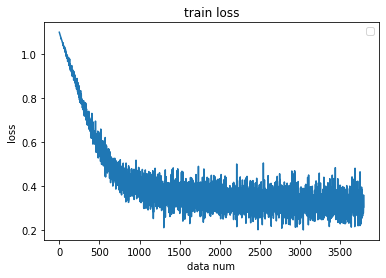

In [17]:
m.plot_loss(loss_his,'train loss','data num')

No handles with labels found to put in legend.


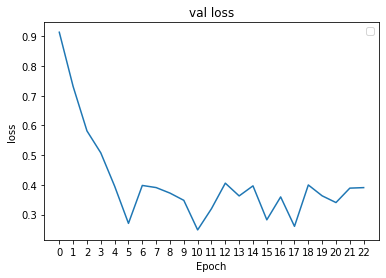

In [18]:
m.plot_loss(val_loss,'val loss','Epoch', x_all=True)

In [19]:
mu, std = data['y_train'].mean(), data['y_train'].std()
print(mu, ' ', std)

0.23974279   0.42692643


In [20]:
m.load_model('best')

In [21]:
m.best_step

1793

In [22]:
m.trial.with_test_generator(t_loader)
t = m.trial.evaluate(data_key=torchbearer.TEST_DATA)

In [23]:
t

{'test_loss': 0.34064555168151855, 'test_acc': 0.8438267707824707}

In [24]:
print(1-t['test_acc'])

0.1561732292175293
